In [7]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import numpy as np
from collections import Counter
import regex as re
import itertools
from itertools import islice

In [21]:
import torch

cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")
if cuda_available:
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")

CUDA Available: True
CUDA Device Name: NVIDIA GeForce RTX 3050


In [22]:
device = 'cuda'

In [8]:
train_path = "C:/Users/Mauri/Desktop/UAM - 3 semestr/modelowanie języka/gap_pred/challenging-america-word-gap-prediction/train/train.txt"

In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
            self,
            sequence_length,
            train_path,
            max_vocab_size=20000
    ):
        self.sequence_length = sequence_length
        self.train_path = train_path
        self.max_vocab_size = max_vocab_size

        self.words = self.load()
        self.uniq_words = self.get_uniq_words()

        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.index_to_word[len(self.index_to_word)] = '<UNK>'
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}
        self.word_to_index['<UNK>'] = len(self.word_to_index)

        self.words_indexes = [self.word_to_index.get(w, self.word_to_index['<UNK>']) for w in self.words]

    def load(self):
        with open(self.train_path, 'r', encoding='utf-8') as f_in:
            text = [x.rstrip() for x in f_in.readlines() if x.strip()]
            text = ' '.join(text).lower()
            text = text.replace('-\\\\n', '').replace('\\\\n', ' ').replace('\\\\t', ' ')
            text = re.sub(r'\n', ' ', text)
            text = re.sub(r'(?<=\w)[,-](?=\w)', '', text)
            text = re.sub(r'\s+', ' ', text)
            text = re.sub(r'\p{P}', '', text)
            text = text.split(' ')
        return text

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        most_common_words = word_counts.most_common(self.max_vocab_size)
        return [word for word, _ in most_common_words]

    def __len__(self):
        return len(self.words_indexes) - self.sequence_length

    def __getitem__(self, index):
        # Get the sequence
        sequence = self.words_indexes[index:index+self.sequence_length]
        # Split the sequence into x and y
        x = sequence[:2] + sequence[-2:]
        y = sequence[len(sequence) // 2]
        return torch.tensor(x), torch.tensor(y)

In [10]:
train_dataset = Dataset(5, train_path)

In [51]:
train_dataset[420]

(tensor([ 14, 110,   3,  28]), tensor(208))

In [53]:
[train_dataset.index_to_word[x] for x in [ 14, 110, 3,  28]]

['at', 'last', 'to', 'tho']

In [54]:
[train_dataset.index_to_word[208]]

['come']

In [52]:
train_dataset[21237]

(tensor([ 218,  104, 8207, 3121]), tensor(20000))

In [12]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, vocab_size, lstm_size=128, embedding_dim=128, num_layers=3, dropout=0.2):
        super(Model, self).__init__()
        self.lstm_size = lstm_size
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=dropout,
        )
        self.fc1 = nn.Linear(self.lstm_size, 256) 
        self.fc2 = nn.Linear(256, vocab_size)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, prev_state=None):
        x = x.to(self.device)
        embed = self.embedding(x)
        embed = embed.transpose(0, 1)
        
        if prev_state is None:
            prev_state = self.init_state(x.size(0))
        
        output, state = self.lstm(embed, prev_state)
        logits = self.fc1(output[-1])
        logits = self.fc2(logits)
        probabilities = self.softmax(logits)
        return probabilities

    def init_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size).to(self.device),
                torch.zeros(self.num_layers, batch_size, self.lstm_size).to(self.device))


In [105]:
def train(dataset, model, max_epochs, batch_size):
    model.train()

    dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    for epoch in range(max_epochs):
        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            y_pred = model(x)
            loss = criterion(torch.log(y_pred), y)

            loss.backward()
            optimizer.step()

            if batch % 500 == 0:
                print({ 'epoch': epoch, 'update in batch': batch, '/' : len(dataloader), 'loss': loss.item() })

In [106]:
model = Model(vocab_size = len(train_dataset.uniq_words) + 1).to(device)
train(train_dataset, model, 1, 8192)

{'epoch': 0, 'update in batch': 0, '/': 16679, 'loss': 9.917818069458008}
{'epoch': 0, 'update in batch': 500, '/': 16679, 'loss': 6.078440189361572}
{'epoch': 0, 'update in batch': 1000, '/': 16679, 'loss': 5.651369571685791}
{'epoch': 0, 'update in batch': 1500, '/': 16679, 'loss': 5.4341654777526855}
{'epoch': 0, 'update in batch': 2000, '/': 16679, 'loss': 5.383695602416992}
{'epoch': 0, 'update in batch': 2500, '/': 16679, 'loss': 5.225739479064941}
{'epoch': 0, 'update in batch': 3000, '/': 16679, 'loss': 5.282474517822266}
{'epoch': 0, 'update in batch': 3500, '/': 16679, 'loss': 5.092397689819336}
{'epoch': 0, 'update in batch': 4000, '/': 16679, 'loss': 4.940906047821045}
{'epoch': 0, 'update in batch': 4500, '/': 16679, 'loss': 4.908115863800049}
{'epoch': 0, 'update in batch': 5000, '/': 16679, 'loss': 5.092423439025879}
{'epoch': 0, 'update in batch': 5500, '/': 16679, 'loss': 4.979565620422363}
{'epoch': 0, 'update in batch': 6000, '/': 16679, 'loss': 4.8268022537231445}
{

In [107]:
torch.save(model.state_dict(), 'model.pth')

In [23]:
model = Model(20001).to(device)

In [24]:
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [2]:
def clean(text):
    text = text.replace('-\\\\n', '').replace('\\\\n', ' ').replace('\\\\t', ' ')
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'(?<=\w)[,-](?=\w)', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\p{P}', '', text)
    text = text.strip()
    return text

In [3]:
def get_words(words, model, dataset, n=20):
    ixs = [dataset.word_to_index.get(word, dataset.word_to_index['<UNK>']) for word in words]
    ixs = torch.tensor(ixs).unsqueeze(0).to(model.device)

    out = model(ixs)
    top = torch.topk(out[0], n)
    top_indices = top.indices.tolist()
    top_probs = top.values.tolist()
    top_words = [dataset.index_to_word[idx] for idx in top_indices]
    return list(zip(top_words, top_probs))

In [4]:
def f_out(left, right, model, dataset):
    left = clean(left)
    right = clean(right)
    words = left.split(' ')[-2:] + right.split(' ')[:2]
    words = get_words(words, model, dataset)

    probs_sum = 0
    output = ''
    for word, prob in words:
        if word == "<UNK>":
            continue
        probs_sum += prob
        output += f"{word}:{prob} "
    output += f":{1-probs_sum}"

    return output

In [6]:
def create_out(input_path, model, dataset, output_path):
    lines = []
    with open(input_path, encoding='utf-8') as f:
        for line in f:
            columns = line.split('\t')
            left = columns[6]
            right = columns[7]
            lines.append((left, right))

    with open(output_path, 'w', encoding='utf-8') as output_file:
        for left, right in lines:
            result = f_out(left, right, model, dataset)
            output_file.write(result + '\n')

In [19]:
dev_path = "C:/Users/Mauri/Desktop/UAM - 3 semestr/modelowanie języka/gap_pred/challenging-america-word-gap-prediction/dev-0/in.tsv"

In [25]:
create_out(dev_path, model, train_dataset, output_path='C:/Users/Mauri/Desktop/UAM - 3 semestr/modelowanie języka/gap_pred/challenging-america-word-gap-prediction/dev-0/out.tsv')

In [26]:
test_path = "C:/Users/Mauri/Desktop/UAM - 3 semestr/modelowanie języka/gap_pred/challenging-america-word-gap-prediction/test-A/in.tsv"

In [27]:
create_out(test_path, model, train_dataset, output_path='C:/Users/Mauri/Desktop/UAM - 3 semestr/modelowanie języka/gap_pred/challenging-america-word-gap-prediction/test-A/out.tsv')

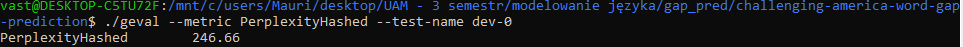

In [2]:
from IPython.display import Image
Image(filename='C:/Users/Mauri/Desktop/Zrzut ekranu 2024-05-27 134020.png')